In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import dask
import dask.dataframe as dd
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

dtypes = {"aggregation_year": 'uint16', "permanent_area": 'float64',
          "seasonal_area": 'float64',
          "maybepermanent": 'float64',
          "maybeseasonal": 'float64'
         }

data_dir = Path.home() / 'pz'
cols_required = ['permanent_area', 
                 # 'seasonal_area'
                #  'maybepermanent', 'maybeseasonal'
                ]
arr_mean_std = []

meta = {'id': 'str', 't_score': 'float', 'u_score': 'float', 'p_t': 'float', 'p_u': 'float', 'reject_null': 'bool'} #'id_bgl': 'object', 'start_year': int, 'basin_level': int
meta_adm0 = {'id': 'str', 'adm0_name': 'str', 't_score': 'float', 'u_score': 'float', 'p_t': 'float', 'p_u': 'float', 'reject_null': 'bool'} #'id_bgl': 'object', 'start_year': int, 'basin_level': int
# meta.update({col: 'float16' for col in cols_required})

def t_test_and_u_test(group, p_thd = 0.001):
    id = group.index[0] # basin_id
    
    patch = group[(group.index == id) & (group['aggregation_year']  >=2000)]
    data1 = list(patch[patch['aggregation_year'] < 2020]['permanent_area'].values)
    data2 = list(patch[patch['aggregation_year'] >= 2017]['permanent_area'].values)

    # T-test
    t_score, p_t = stats.ttest_ind(data1, data2)

    # U-Test
    u_score, p_u = stats.mannwhitneyu(data1, data2)

    # P-value is defined as the probability under the assumption of no effect or no difference (null hypothesis), 
    # of obtaining a result equal to or more extreme than what was actually observed
    # P-values close to 0 indicate that the observed difference is unlikely to be due to chance, (true difference?)
    # whereas a P value close to 1 suggests no difference between the groups other than due to chance (no difference?)
    reject_null = (p_t < p_thd) or (p_u < p_thd) # True: different, False: no difference

    if 'adm0_name' in group.columns:
        adm0_name = group['adm0_name'].iloc[0]
        df = pd.DataFrame([[id, adm0_name, t_score, u_score, p_t, p_u, float(reject_null)]], columns=['id', 'adm0_name', 't_score', 'u_score', 'p_t', 'p_u', 'reject_null'])
    else:
        df = pd.DataFrame([[id, t_score, u_score, p_t, p_u, float(reject_null)]], columns=['id', 't_score', 'u_score', 'p_t', 'p_u', 'reject_null'])
    return df




# if __name__ == '__main__':
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(dashboard_address=':38787')
client = Client(cluster)#timeout


output_dir = data_dir / f"outputs_ttest" / folder
output_dir.mkdir(exist_ok=True, parents=True)
print(output_dir)

for folder in ["Pemanent_water"]: # Reservoirs, Pemanent_water

    # country-level analysis
    basin = dd.read_csv(data_dir / folder / 'gaul_0_ts.csv', include_path_column=False, dtype=dtypes).repartition(npartitions=80).set_index('adm0_code')
    df_delta = basin.groupby('adm0_code', group_keys=False).apply(t_test_and_u_test, meta=meta_adm0)
    df_delta.compute().to_csv(output_dir / f"gaul_0_t_test.csv")

    # basin-level analysis
    for basin_level in [0, 3, 4, 5, 6, 7, 8]:
        print()
        print(f"basins_level: {basin_level}")
    
        url = data_dir / folder / f"basins_level_{basin_level}_ts.csv"
        basin = dd.read_csv(url, include_path_column=False, dtype=dtypes).repartition(npartitions=80).set_index(f'id_bgl_{basin_level}')
        
        ''' for debug '''
        # number = 31
        # df_delta = basin.groupby(f'id_bgl_{basin_level}', group_keys=False)
        # t_test_and_u_test(df_delta.get_group("112_262").compute(), basin_level)
    
        # df_delta = basin.groupby(f'id_bgl_{basin_level}', group_keys=False).apply(calculate_delta, basin_level, epision, meta=meta)
        df_delta = basin.groupby(f'id_bgl_{basin_level}', group_keys=False).apply(t_test_and_u_test, meta=meta).set_index('id')
       
        df_delta = df_delta.compute()
        df_delta.to_csv(output_dir / f"basins_level_{basin_level}_t_test.csv")


In [19]:
[0] + list(range(3, 9))

[0, 3, 4, 5, 6, 7, 8]

In [61]:
basin = pd.read_csv("outputs_t_test/Pemanent_water/basins_level_6_t_test.csv")
print(f"total number: {basin.shape[0]}")
print(f"number of increase/descrease: {basin['reject_null'].values.sum()}")
print(f"percentage of increase/descrease (%): {basin['reject_null'].values.sum() / basin.shape[0] * 100}")
basin


total number: 19163
number of increase/descrease: 236.0
percentage of increase/descrease (%): 1.231539946772426


,Unnamed: 0,id,t_score,u_score,p_t,p_u,reject_null
0,0,111011_818,NaN,50.0,NaN,1.0,0.0
1,0,111012_818,NaN,50.0,NaN,1.0,0.0
2,0,111013_818,NaN,50.0,NaN,1.0,0.0
3,0,111014_818,NaN,50.0,NaN,1.0,0.0
4,0,111015_818,NaN,50.0,NaN,1.0,0.0
...,...,...,...,...,...,...,...
19158,0,999999_31,NaN,50.0,NaN,1.0,0.0
19159,0,999999_364,NaN,50.0,NaN,1.0,0.0
19160,0,999999_398,NaN,50.0,NaN,1.0,0.0
19161,0,999999_643,NaN,50.0,NaN,1.0,0.0


# Country-Level Delta

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import dask
import dask.dataframe as dd

dtypes = {"aggregation_year": 'uint16',
          "permanent_area": 'float64', 
          "seasonal_area": 'float64',
          "maybepermanent": 'float64',
          "maybeseasonal": 'float64'
         }

data_dir = Path.home() / 'pz'
cols_required = ['permanent_area', 
                 # 'seasonal_area'
                #  'maybepermanent', 'maybeseasonal'
                ]
arr_mean_std = []

meta = {'id_bgl': 'object', 'adm0_name': 'object', 'start_year': int, 'basin_level': int} #'id_bgl': 'object', 'start_year': int, 'basin_level': int
meta.update({col: 'float16' for col in cols_required})


def calculate_delta(group, basin_level, epision=1e-15):
    # group = group.reset_index() # needed for drop
    id = group.index[0]
    adm0_name = group['adm0_name'].iloc[0]
    
    df_2000_2019 = group[ (2000 <= group['aggregation_year']) & (group['aggregation_year']<= 2019)]
    beta_baseline_median = df_2000_2019[cols_required].median()

    arr_delta = []
    # for start_year in [2000, 2005, 2010, 2015, 2017]:
    for start_year in [2017]:
        df_5y = group[ (start_year <= group['aggregation_year']) & (group['aggregation_year'] < start_year + 5)]
        gamma_5y_median = df_5y[cols_required].median()

        # solution 1: 
        delta = (gamma_5y_median - beta_baseline_median) / (beta_baseline_median + epision) * 100

        delta_cols = list([delta[col].values for col in [cols_required]][0])
        arr_delta.append([id, adm0_name, start_year, basin_level] + delta_cols)
    
    df_delta = pd.DataFrame(data=arr_delta, columns=['id_bgl', 'adm0_name', 'start_year', 'basin_level'] + cols_required)
    return df_delta

def remove_outliers(df, p_low, p_high):
    for col in ['permanent_area']:
        select = (df[col] > p_low[col]) & (df[col] < p_high[col])
        df = df[select]
    return df


if __name__ == '__main__':
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster(dashboard_address=':38787')
    client = Client(cluster)#timeout

    p_low = 2 # remove lowest 1%
    p_high = 98 # remove highest 4%
    epision = 1e-15
    
    for folder in  ["Reservoirs", "Pemanent_water"]: # Reservoirs, Pemanent_water
        output_dir = data_dir / f"outputs_V2_p{p_low}_p{p_high}_e15_2017" / folder
        output_dir.mkdir(exist_ok=True, parents=True)
        print(output_dir)
    
        # for basin_level in range(3,9):
    
        basin_level = 'gaul_0'
        url = data_dir / folder / f"gaul_0_ts.csv"
        basin = dd.read_csv(url, include_path_column=False, dtype=dtypes).repartition(npartitions=80).set_index('adm0_code')
        
        df_delta = basin.groupby('adm0_code', group_keys=False).apply(calculate_delta, basin_level, epision, meta=meta)
        df_delta = df_delta.compute()
    
        # remove the rows where delta > 100, since we assume that this may be caused by the case when  
        df_delta_ = df_delta[cols_required][df_delta['permanent_area'] <= 100]
        p_low_value = df_delta_[cols_required].quantile(p_low * 0.01)#.compute()
        p_high_value = df_delta_[cols_required].quantile(p_high * 0.01)#.compute()
    
        print('p_low')
        print(p_low_value)
        print('p_high')
        print(p_high_value)
    
        df_delta.to_csv(output_dir / f"{basin_level}_ts_delta.csv")
        
        df = remove_outliers(df_delta_, p_low_value, p_high_value)
        
        print()
        print(df.describe())
        df.to_csv(output_dir / f"{basin_level}_ts_delta_outliers_removed.csv")
    
        # save hist
        import matplotlib.pyplot as plt
        for col in cols_required:
            plt.figure()
            df[col].plot(kind='hist', logy=True, bins=200)
            plt.title(f'basin level: {basin_level}, {col}')
            plt.savefig(output_dir / f"{basin_level}_hist_{col}.png")
            plt.close()
    
        # calculate mean and std
        row = [basin_level] + list(df[cols_required].mean().values) + list(df[cols_required].std().values)
        arr_mean_std.append(row)
    
        col_names = ['basin_level'] + [f'mean_{col}' for col in cols_required] + [f'std_{col}' for col in cols_required]
        print(arr_mean_std)
        
        df_mean_std = pd.DataFrame(data=arr_mean_std, columns=col_names)
        # df_mean_std.to_csv(output_dir / f"{basin_level}_mean_std.csv")
        df_mean_std.to_csv(output_dir / f"gaul_0_mean_std.csv")
        print("finish")
        

# Abalysis on Delta and T-Test

In [59]:
# apply threshold
def apply_threshold(input, thd_low, thd_high):
    stb = input[(input['permanent_area'] >= thd_low) & (input['permanent_area'] <= thd_high)]
    neg = input[(input['permanent_area'] < thd_low)]
    pos = input[(input['permanent_area'] > thd_high)]
    return neg, stb, pos


data_dir = Path.home() / 'pz'
ttest_dir = data_dir / "outputs_ttest"
delta_dir = data_dir / "outputs_delta"

folder = "Reservoirs" # Reservoirs
basin_level = 4


''' t-TEST and u-TEST '''
# ttest = pd.read_csv(ttest_dir / folder / f"basins_level_{basin_level}_ttest.csv")

''' Delta (2017)  '''
# delta
delta_all = pd.read_csv(delta_dir / folder / f"basins_level_{basin_level}_ts_delta.csv")
delta_2017 = delta_all[delta_all['start_year']==2017]
total_num_basins = delta_2017.shape[0]
print(f"basin_level: {basin_level}, total number of basins: {total_num_basins}")

# mean and std
df_muStd = pd.read_csv(delta_dir / folder / "basin_level_mean_std.csv").set_index('basin_level')
mean = df_muStd['mean_permanent_area'][basin_level]
std = df_muStd['std_permanent_area'][basin_level]
print(f"(all years), mean: {mean}, std: {std}")

# delta outliers removed
delta_all_outliers_removed = pd.read_csv(delta_dir / folder / f"basins_level_{basin_level}_ts_delta_outliers_removed.csv")
delta_2017_rm = delta_all_outliers_removed[delta_all_outliers_removed['start_year']==2017]
des_2017 = delta_2017_rm.describe()
mean_2017 = des_2017.loc['mean', 'permanent_area']
std_2017 = des_2017.loc['std', 'permanent_area']
print(f"(2017) mean: {mean_2017}, std: {std_2017}")


res_arr = []
# for start_year in [2000, 2005, 2010, 2015, 2017]:
start_year = 2017
print()
print(f'+++++++++++++++++++++++++++++++++ {start_year} ++++++++++++++++++++++++++++++++++')
for alpha in [0.5, 1, 1.5, 2]:
    print()
    
    print(f"--------- apply all years thresholds (alpha = {alpha}) -----------")
    thd_high = mean + alpha * std
    thd_low = mean - alpha * std
    print(f"(all years, alpha = {alpha}), [{thd_low}, {thd_high}]")
    neg, stb, pos = apply_threshold(delta_2017, thd_low, thd_high)
    print(f"neg: {neg.shape[0]}, stable: {stb.shape[0]}, pos: {pos.shape[0]}")
    print(f"neg: {neg.shape[0] / total_num_basins * 100}, stable: {stb.shape[0] / total_num_basins * 100}, pos: {pos.shape[0] / total_num_basins * 100}")
    
    print(f"---------- apply 2017 thresholds (alpha = {alpha}) --------------")
    thr_2017_high = mean_2017 + alpha * std_2017
    thr_2017_low = mean_2017 - alpha * std_2017
    print(f"(2017, alpha = {alpha}), [{thr_2017_low}, {thr_2017_high}]")
    neg_th17, stb_th17, pos_th17 = apply_threshold(delta_2017, thr_2017_low, thr_2017_high)
    print(f"neg: {neg_th17.shape[0]}, stable: {stb_th17.shape[0]}, pos: {pos_th17.shape[0]}")
    print(f"neg: {neg_th17.shape[0] / total_num_basins * 100}, stable: {stb_th17.shape[0] / total_num_basins * 100}, pos: {pos_th17.shape[0] / total_num_basins * 100}")

        # [basin_level, num_basins, mean, std, aplha, thd_low, thd_high, neg.shape[0], stb.shape[0], pos.shape[0]]


basin_level: 4, total number of basins: 2212
(all years), mean: -0.2264190422649588, std: 5.02476409052992
(2017) mean: -0.06997839408883126, std: 5.046409883761399

+++++++++++++++++++++++++++++++++ 2017 ++++++++++++++++++++++++++++++++++

--------- apply all years thresholds (alpha = 0.5) -----------
(all years, alpha = 0.5), [-2.738801087529919, 2.285963003000001]
neg: 182, stable: 1708, pos: 322
neg: 8.227848101265822, stable: 77.21518987341773, pos: 14.556962025316455
---------- apply 2017 thresholds (alpha = 0.5) --------------
(2017, alpha = 0.5), [-2.5931833359695307, 2.453226547791868]
neg: 188, stable: 1708, pos: 316
neg: 8.499095840867993, stable: 77.21518987341773, pos: 14.285714285714285

--------- apply all years thresholds (alpha = 1) -----------
(all years, alpha = 1), [-5.251183132794878, 4.798345048264961]
neg: 132, stable: 1809, pos: 271
neg: 5.967450271247739, stable: 81.78119349005425, pos: 12.25135623869801
---------- apply 2017 thresholds (alpha = 1) ------------

In [67]:
delta_2017[delta_2017['permanent_area']>100]

,id_bgl,start_year,basin_level,permanent_area
4,1110_232,2017,4,6.909797e+03
194,1153_404,2017,4,5.453242e+16
199,1154_231,2017,4,3.019360e+02
364,1179_508,2017,4,1.465391e+02
514,1229_894,2017,4,9.915995e+02
...,...,...,...,...
8749,6424_600,2017,4,1.063055e+16
9564,7239_124,2017,4,4.097593e+02
9974,7539_188,2017,4,1.499850e+02
10099,7711_188,2017,4,1.287145e+04


In [82]:
# pz/Pemanent_water/basins_level_4_ts.csv
ts_all = pd.read_csv(data_dir / folder / f"basins_level_4_ts.csv")
ts = ts_all[(ts_all['id_bgl_4']=='6424_600') & (ts_all['aggregation_year'] >= 2000)]
ts

,id_bgl_4,aggregation_year,permanent_area,seasonal_area
52608,6424_600,2000,0.000000,0.000824
52609,6424_600,2001,0.000000,0.023898
52610,6424_600,2002,0.000000,0.023898
52611,6424_600,2003,0.000000,0.000824
52612,6424_600,2004,0.000000,0.000824
52613,6424_600,2005,0.000000,0.000824
52614,6424_600,2006,0.000000,0.000824
52615,6424_600,2007,0.000000,0.000824
52616,6424_600,2008,0.000000,0.000824
52617,6424_600,2009,0.000000,0.000824


In [64]:
delta_2017_rm

,id_bgl,start_year,basin_level,permanent_area
7,1110_729,2017,4,0.0
12,1110_818,2017,4,0.0
17,1120_231,2017,4,0.0
22,1120_706,2017,4,0.0
27,1121_231,2017,4,0.0
...,...,...,...,...
10401,9999_31,2017,4,0.0
10406,9999_364,2017,4,0.0
10411,9999_398,2017,4,0.0
10416,9999_643,2017,4,0.0


In [8]:
''' T-Test '''

data_dir = Path.home() / 'pz'
ttest_dir = data_dir / "outputs_ttest"

for folder in ["Pemanent_water", "Reservoirs"]: # Reservoirs, Pemanent_water
    print(folder)
    res = []
    p_thd_list = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
    p_thd_cols = [f'p_thd_{p_thd}' for p_thd in p_thd_list]
    for basin_level in [0, 3, 4, 5, 6, 7, 8]:
        url = ttest_dir / folder / f"basins_level_{basin_level}_t_test.csv"
        print(url)
        ttest = pd.read_csv(url)
        
        num_change_list = []
        for p_thd in p_thd_list:
            # P-values close to 0 indicate that the observed difference is unlikely to be due to chance, (true difference?)
            # whereas a P value close to 1 suggests no difference between the groups other than due to chance (no difference?)
            arr = ((ttest['p_t'] < p_thd).values | (ttest['p_u'] < p_thd).values).astype(float)
            ttest[f'p_thd_{p_thd}'] = arr # True: different, False: no difference
            num_change = int(arr.sum())
            # print(f"p_thd: {p_thd}, num of changes: {num_change}")
            num_change_list.append(num_change)
        res.append([basin_level, 2017, ] + num_change_list)
    
    ttest_res = pd.DataFrame(res, columns=['basin_level', 'start_year'] + p_thd_cols).set_index('basin_level')
    ttest_res.to_csv(ttest_dir / f'{folder}_ttest_2017.csv')

Pemanent_water
/users/zhanghui/pz/outputs_ttest/Pemanent_water/basins_level_0_t_test.csv
/users/zhanghui/pz/outputs_ttest/Pemanent_water/basins_level_3_t_test.csv
/users/zhanghui/pz/outputs_ttest/Pemanent_water/basins_level_4_t_test.csv
/users/zhanghui/pz/outputs_ttest/Pemanent_water/basins_level_5_t_test.csv
/users/zhanghui/pz/outputs_ttest/Pemanent_water/basins_level_6_t_test.csv
/users/zhanghui/pz/outputs_ttest/Pemanent_water/basins_level_7_t_test.csv
/users/zhanghui/pz/outputs_ttest/Pemanent_water/basins_level_8_t_test.csv
Reservoirs
/users/zhanghui/pz/outputs_ttest/Reservoirs/basins_level_0_t_test.csv
/users/zhanghui/pz/outputs_ttest/Reservoirs/basins_level_3_t_test.csv
/users/zhanghui/pz/outputs_ttest/Reservoirs/basins_level_4_t_test.csv
/users/zhanghui/pz/outputs_ttest/Reservoirs/basins_level_5_t_test.csv
/users/zhanghui/pz/outputs_ttest/Reservoirs/basins_level_6_t_test.csv
/users/zhanghui/pz/outputs_ttest/Reservoirs/basins_level_7_t_test.csv
/users/zhanghui/pz/outputs_ttest/Res

In [ ]:
''' Thresolding Delta with Mean and STD '''

import numpy as np
import pandas as pd
from pathlib import Path

# apply threshold
def apply_threshold(input, thd_low, thd_high):
    stb = input[(input['permanent_area'] >= thd_low) & (input['permanent_area'] <= thd_high)]
    neg = input[(input['permanent_area'] < thd_low)]
    pos = input[(input['permanent_area'] > thd_high)]
    return neg, stb, pos

data_dir = Path.home() / 'pz'
ttest_dir = data_dir / "outputs_ttest"
delta_dir = data_dir / "outputs_delta"

folder = "Reservoirs" # Reservoirs, Pemanent_water

''' Delta (2017)  '''
res_arr = []
for basin_level in [0, 3, 4, 5, 6, 7, 8]:
    # delta
    delta_all = pd.read_csv(delta_dir / folder / f"basins_level_{basin_level}_ts_delta.csv")

    # mean and std over all years
    df_muStd = pd.read_csv(delta_dir / folder / "basin_level_mean_std.csv").set_index('basin_level')
    mean = df_muStd['mean_permanent_area'][basin_level]
    std = df_muStd['std_permanent_area'][basin_level]
    print(f"(all years), mean: {mean}, std: {std}")
    
    # delta outliers removed
    delta_all_outliers_removed = pd.read_csv(delta_dir / folder / f"basins_level_{basin_level}_ts_delta_outliers_removed.csv")

    for start_year in [2000, 2005, 2010, 2015, 2017]:
    # for start_year in [2017]:
        delta = delta_all[delta_all['start_year']==start_year]
        num_basins = delta.shape[0]

        # # delta outliers removed
        # if start_year == 2017:
        #     delta_rm = delta_all_outliers_removed[delta_all_outliers_removed['start_year']==start_year]
        #     des_rm = delta_rm.describe()
        #     mean = des_rm.loc['mean', 'permanent_area']
        #     std = des_rm.loc['std', 'permanent_area']
        #     print(f"(start_year) mean: {mean}, std: {std}")
    
        print()
        print(f'+++++++++++++++++++++++++++++++++ basin_level: {basin_level}: {start_year} ++++++++++++++++++++++++++++++++++')
        for alpha in [0.5, 1, 1.5, 2]:
            print(f"--------- apply all years thresholds (alpha = {alpha}) -----------")
            thd_high = mean + alpha * std
            thd_low = mean - alpha * std
            print(f"(all years, alpha = {alpha}), [{thd_low}, {thd_high}]")
            neg, stb, pos = apply_threshold(delta, thd_low, thd_high)
            print(f"neg: {neg.shape[0]}, stable: {stb.shape[0]}, pos: {pos.shape[0]}")
            print(f"neg: {neg.shape[0] / num_basins * 100}, stable: {stb.shape[0] / num_basins * 100}, pos: {pos.shape[0] / num_basins * 100}")
                
            row = [basin_level, num_basins, start_year, mean, std, alpha, thd_low, thd_high, neg.shape[0], stb.shape[0], pos.shape[0]]
            res_arr.append(row)

col_names = ['basin_level', 'num_basins', 'start_year', 'mean', 'std', 'aplha', 'thd_low', 'thd_high', 'neg', 'stable', 'pos']
df_res = pd.DataFrame(res_arr, columns=col_names)
df_res.set_index('basin_level').to_csv(delta_dir / f"{folder}_delta.csv")
df_res

In [4]:
''' Thresolding Delta with Mean and STD (2017) '''

import numpy as np
import pandas as pd
from pathlib import Path

# apply threshold
def apply_threshold(input, thd_low, thd_high):
    stb = input[(input['permanent_area'] >= thd_low) & (input['permanent_area'] <= thd_high)]
    neg = input[(input['permanent_area'] < thd_low)]
    pos = input[(input['permanent_area'] > thd_high)]
    return neg, stb, pos

data_dir = Path.home() / 'pz'
ttest_dir = data_dir / "outputs_ttest"
delta_dir = data_dir / "outputs_delta"

for folder in ["Reservoirs", "Pemanent_water"]: # Reservoirs, Pemanent_water

    ''' Delta (2017)  '''
    res_arr = []
    for basin_level in [0, 3, 4, 5, 6, 7, 8]:
        # delta
        delta_all = pd.read_csv(delta_dir / folder / f"basins_level_{basin_level}_ts_delta.csv")
    
        # mean and std over all years
        df_muStd = pd.read_csv(delta_dir / folder / "basin_level_mean_std.csv").set_index('basin_level')
        mean = df_muStd['mean_permanent_area'][basin_level]
        std = df_muStd['std_permanent_area'][basin_level]
        print(f"(all years), mean: {mean}, std: {std}")
        
        # delta outliers removed
        delta_all_outliers_removed = pd.read_csv(delta_dir / folder / f"basins_level_{basin_level}_ts_delta_outliers_removed.csv")
    
        # for start_year in [2000, 2005, 2010, 2015, 2017]:
        for start_year in [2017]:
            delta = delta_all[delta_all['start_year']==start_year]
            num_basins = delta.shape[0]
    
            # # delta outliers removed
            # if start_year == 2017:
            #     delta_rm = delta_all_outliers_removed[delta_all_outliers_removed['start_year']==start_year]
            #     des_rm = delta_rm.describe()
            #     mean = des_rm.loc['mean', 'permanent_area']
            #     std = des_rm.loc['std', 'permanent_area']
            #     print(f"(start_year) mean: {mean}, std: {std}")
        
            print()
            print(f'+++++++++++++++++++++++++++++++++ basin_level: {basin_level}: {start_year} ++++++++++++++++++++++++++++++++++')
            for alpha in [0.5, 1, 1.5, 2, 2.5, 3, 4, 5]:
                print(f"--------- apply all years thresholds (alpha = {alpha}) -----------")
                thd_high = mean + alpha * std
                thd_low = mean - alpha * std
                print(f"(all years, alpha = {alpha}), [{thd_low}, {thd_high}]")
                neg, stb, pos = apply_threshold(delta, thd_low, thd_high)
                print(f"neg: {neg.shape[0]}, stable: {stb.shape[0]}, pos: {pos.shape[0]}")
                print(f"neg: {neg.shape[0] / num_basins * 100}, stable: {stb.shape[0] / num_basins * 100}, pos: {pos.shape[0] / num_basins * 100}")
                    
                row = [basin_level, num_basins, start_year, mean, std, alpha, thd_low, thd_high, neg.shape[0], stb.shape[0], pos.shape[0]]
                res_arr.append(row)
    
    col_names = ['basin_level', 'num_basins', 'start_year', 'mean', 'std', 'aplha', 'thd_low', 'thd_high', 'neg', 'stable', 'pos']
    df_res = pd.DataFrame(res_arr, columns=col_names)
    df_res.set_index('basin_level').to_csv(delta_dir / f"{folder}_delta_2017_allThd.csv")


(all years), mean: 0.2194801005543315, std: 5.016068843874664

+++++++++++++++++++++++++++++++++ basin_level: 0: 2017 ++++++++++++++++++++++++++++++++++
--------- apply all years thresholds (alpha = 0.5) -----------
(all years, alpha = 0.5), [-2.2885543213830006, 2.7275145224916635]
neg: 30, stable: 191, pos: 57
neg: 10.79136690647482, stable: 68.70503597122301, pos: 20.503597122302157
--------- apply all years thresholds (alpha = 1) -----------
(all years, alpha = 1), [-4.796588743320332, 5.235548944428996]
neg: 21, stable: 212, pos: 45
neg: 7.553956834532374, stable: 76.2589928057554, pos: 16.18705035971223
--------- apply all years thresholds (alpha = 1.5) -----------
(all years, alpha = 1.5), [-7.304623165257665, 7.7435833663663285]
neg: 12, stable: 224, pos: 42
neg: 4.316546762589928, stable: 80.57553956834532, pos: 15.107913669064748
--------- apply all years thresholds (alpha = 2) -----------
(all years, alpha = 2), [-9.812657587194996, 10.25161778830366]
neg: 7, stable: 235, po

In [61]:
''' T-Test '''

data_dir = Path.home() / 'pz'
ttest_dir = data_dir / "outputs_ttest"

for folder in ["Pemanent_water", "Reservoirs"]: # Reservoirs, Pemanent_water
    res = []
    p_thd_list = [0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]
    p_thd_cols = [f'p_thd_{p_thd}' for p_thd in p_thd_list]
    for basin_level in range(3, 9):
        ttest = pd.read_csv(ttest_dir / folder / f"basins_level_{basin_level}_t_test.csv")
        num_change_list = []
        for p_thd in p_thd_list:
            # P-values close to 0 indicate that the observed difference is unlikely to be due to chance, (true difference?)
            # whereas a P value close to 1 suggests no difference between the groups other than due to chance (no difference?)
            arr = ((ttest['p_t'] < p_thd).values | (ttest['p_u'] < p_thd).values).astype(float)
            ttest[f'p_thd_{p_thd}'] = arr # True: different, False: no difference
            num_change = int(arr.sum())
            # print(f"p_thd: {p_thd}, num of changes: {num_change}")
            num_change_list.append(num_change)
        res.append([basin_level, 2017, ] + num_change_list)
    
    ttest_res = pd.DataFrame(res, columns=['basin_level', 'start_year'] + p_thd_cols).set_index('basin_level')
    ttest_res.to_csv(ttest_dir / f'{folder}_ttest_2017.csv')

In [62]:
ttest_res

,start_year,p_thd_0.001,p_thd_0.01,p_thd_0.02,p_thd_0.05,p_thd_0.1,p_thd_0.2,p_thd_0.5
basin_level,,,,,,,,
3,2017,24,85,103,149,174,224,307
4,2017,55,194,244,326,372,486,650
5,2017,121,379,482,679,816,1021,1364
6,2017,236,794,1032,1477,1806,2241,2947
7,2017,3080,10962,13886,19848,24230,30398,40872
8,2017,8719,30557,39102,56024,68554,86031,116573


In [185]:
df_res[df_res['basin_level'] == 3]

,basin_level,num_basins,start_year,mean,std,aplha,thd_low,thd_high,neg,stable,pos
0,3,0,2000,3.317735,24.105957,0.5,-8.735243,15.370713,0,0,0
1,3,0,2000,3.317735,24.105957,1.0,-20.788222,27.423692,0,0,0
2,3,0,2000,3.317735,24.105957,1.5,-32.841200,39.476670,0,0,0
3,3,0,2000,3.317735,24.105957,2.0,-44.894179,51.529649,0,0,0
4,3,0,2005,3.317735,24.105957,0.5,-8.735243,15.370713,0,0,0
5,3,0,2005,3.317735,24.105957,1.0,-20.788222,27.423692,0,0,0
6,3,0,2005,3.317735,24.105957,1.5,-32.841200,39.476670,0,0,0
7,3,0,2005,3.317735,24.105957,2.0,-44.894179,51.529649,0,0,0
8,3,0,2010,3.317735,24.105957,0.5,-8.735243,15.370713,0,0,0
9,3,0,2010,3.317735,24.105957,1.0,-20.788222,27.423692,0,0,0


In [38]:
ttest_res

,start_year,p_thd_0.001,p_thd_0.01,p_thd_0.02,p_thd_0.05,p_thd_0.1,p_thd_0.2,p_thd_0.5
basin_level,,,,,,,,
3,2017,24,85,103,149,174,224,307
4,2017,55,194,244,326,372,486,650
5,2017,121,379,482,679,816,1021,1364
6,2017,236,794,1032,1477,1806,2241,2947
7,2017,3080,10962,13886,19848,24230,30398,40872
8,2017,8719,30557,39102,56024,68554,86031,116573


In [129]:
(ttest['p_t'] < p_thd).values & (ttest['p_t'] < p_thd).values

array([False, False, False, ..., False, False, False])

In [119]:
ttest

,Unnamed: 0,id,t_score,u_score,p_t,p_u,reject_null
0,0,111011_818,NaN,50.0,NaN,1.0,0.0
1,0,111012_818,NaN,50.0,NaN,1.0,0.0
2,0,111013_818,NaN,50.0,NaN,1.0,0.0
3,0,111014_818,NaN,50.0,NaN,1.0,0.0
4,0,111015_818,NaN,50.0,NaN,1.0,0.0
...,...,...,...,...,...,...,...
19158,0,999999_31,NaN,50.0,NaN,1.0,0.0
19159,0,999999_364,NaN,50.0,NaN,1.0,0.0
19160,0,999999_398,NaN,50.0,NaN,1.0,0.0
19161,0,999999_643,NaN,50.0,NaN,1.0,0.0


In [102]:
delta_2017

,Unnamed: 0,id_bgl,start_year,basin_level,permanent_area
4,4,111011_818,2017,6,7.824869e+01
9,4,111012_818,2017,6,2.338167e+14
14,4,111013_818,2017,6,9.493417e+01
19,4,111014_818,2017,6,0.000000e+00
24,4,111015_818,2017,6,2.864859e+01
...,...,...,...,...,...
95794,4,999999_31,2017,6,1.462119e+01
95799,4,999999_364,2017,6,4.903598e+00
95804,4,999999_398,2017,6,5.591307e+00
95809,4,999999_643,2017,6,4.728585e+00


In [98]:
ttest

,Unnamed: 0,id,t_score,u_score,p_t,p_u,reject_null
0,0,111011_818,NaN,50.0,NaN,1.0,0.0
1,0,111012_818,NaN,50.0,NaN,1.0,0.0
2,0,111013_818,NaN,50.0,NaN,1.0,0.0
3,0,111014_818,NaN,50.0,NaN,1.0,0.0
4,0,111015_818,NaN,50.0,NaN,1.0,0.0
...,...,...,...,...,...,...,...
19158,0,999999_31,NaN,50.0,NaN,1.0,0.0
19159,0,999999_364,NaN,50.0,NaN,1.0,0.0
19160,0,999999_398,NaN,50.0,NaN,1.0,0.0
19161,0,999999_643,NaN,50.0,NaN,1.0,0.0


In [68]:
mean = delta_2017_rm.describe().loc['mean', 'permanent_area']
std = delta_2017_rm.describe().loc['std', 'permanent_area']
mean, std

(8.34240496058404, 37.37278602876034)

In [91]:
muStd['mean_permanent_area'][3]

3.860604780894815

In [7]:
df = pd.read_csv("Pemanent_water/basins_level_3_ts.csv")
df

,id_bgl_3,aggregation_year,permanent_area,seasonal_area,maybepermanent,maybeseasonal
0,281_4,1984,0.086041,0.941157,6.998242,64.979896
1,281_4,1985,2.839203,11.778050,3.703471,42.652496
2,281_4,1986,4.508320,28.517788,1.126824,12.752676
3,281_4,1987,3.886502,42.684376,0.000000,0.741167
4,281_4,1988,0.918988,1.685255,4.825939,51.630339
...,...,...,...,...,...,...
29597,437_156,2017,134.967326,534.969366,0.000000,2.219586
29598,437_156,2018,116.720183,540.976530,0.000819,0.693052
29599,437_156,2019,128.120326,519.056898,0.000000,1.058137
29600,437_156,2020,126.832439,506.721885,0.000000,1.453982


In [17]:
for folder in  ['Pemanent_water', 'Reservoirs']:
    df = pd.read_csv(f"{folder}/gaul_0_ts.csv")
    df = df.rename(columns={'adm0_code': 'id_bgl_0'}).drop(columns=['adm0_name']).set_index('id_bgl_0')
    df.to_csv(f"{folder}/basins_level_0_ts.csv")

In [11]:
df

In [22]:
df.describe()

,permanent_area
count,1316.000000
mean,0.219480
std,5.016069
min,-23.868965
25%,0.000000
50%,0.000000
75%,0.032760
max,31.033865


In [4]:
df1 = df.dropna()
df1

,permanent_area,seasonal_area
0,31.011823,-43.478594
1,-3.004938,38.428279
2,-0.709077,-2.681153
3,-0.677151,16.563266
4,-0.677151,23.913384
...,...,...
0,-2.887968,-12.002541
1,3.048440,-27.252117
2,0.428377,1.004196
3,2.017455,9.354866


<Axes: ylabel='Frequency'>

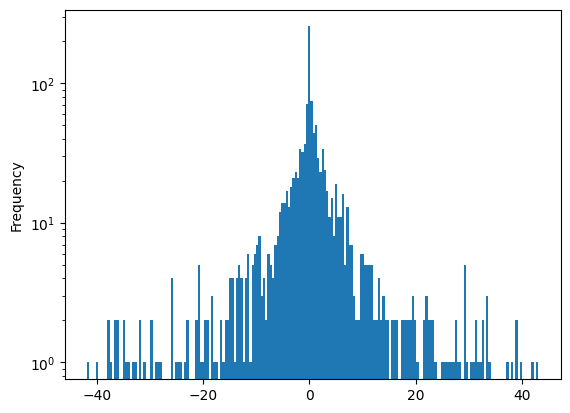

In [14]:
df[col].plot(kind='hist', logy=True, bins=200)

In [79]:
df_delta['permanent_area'].dropna().describe()

count    1220.000000
mean       15.719838
std       213.174681
min      -100.000000
25%        -2.576460
50%         0.089842
75%         3.303374
max      4951.987928
Name: permanent_area, dtype: float64

In [81]:
df_delta['permanent_area'].dropna().describe()

count    1220.000000
mean       15.719838
std       213.174681
min      -100.000000
25%        -2.576460
50%         0.089842
75%         3.303374
max      4951.987928
Name: permanent_area, dtype: float64